In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import math


In [2]:
# Dataset paths
train_dir = r'C:\Users\Yashuu\Downloads\WFD(MAIN)\Classification\train'
valid_dir = r'C:\Users\Yashuu\Downloads\WFD(MAIN)\Classification\valid'
test_dir = r'C:\Users\Yashuu\Downloads\WFD(MAIN)\Classification\test'


In [3]:
# Data Augmentation (Optimized)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Data Generators
batch_size = 16
target_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, batch_size=batch_size, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=target_size, batch_size=batch_size, class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=False)


Found 1140 images belonging to 2 classes.
Found 380 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


In [5]:
# Learning Rate Scheduler (Cosine Annealing)
def cosine_annealing(epoch):
    initial_lr = 0.0001
    lr = initial_lr * (math.cos(epoch / 15 * math.pi) + 1) / 2
    return lr
lr_scheduler = LearningRateScheduler(cosine_annealing)


In [6]:
# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16

# Load Pretrained VGG16 but only keep first 2 blocks
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Manually keep only first 6 layers (Conv + Pooling)
reduced_vgg = Sequential()
for layer in base_model.layers[4:]:  # Keeping first 6 layers
    reduced_vgg.add(layer)

# Freeze these layers to avoid training them
for layer in reduced_vgg.layers:
    layer.trainable = True

# Custom Head
model = Sequential([
    reduced_vgg,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
# Train Model
history = model.fit(
    train_generator, 
    validation_data=valid_generator, 
    epochs= 30, 
    callbacks=[lr_reduce, early_stop, checkpoint, lr_scheduler]
)


Epoch 1/30
72/72 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9702
Epoch 1: val_loss improved from 0.46128 to 0.45273, saving model to best_model.h5
72/72 [==============================] - 156s 2s/step - loss: 0.1499 - accuracy: 0.9702 - val_loss: 0.4527 - val_accuracy: 0.8184 - lr: 1.0000e-04
Epoch 2/30


C:\Users\Yashuu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - ETA: 0s - loss: 0.1521 - accuracy: 0.9596
Epoch 2: val_loss improved from 0.45273 to 0.44376, saving model to best_model.h5
72/72 [==============================] - 136s 2s/step - loss: 0.1521 - accuracy: 0.9596 - val_loss: 0.4438 - val_accuracy: 0.8158 - lr: 9.8907e-05
Epoch 3/30
72/72 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9632
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.8703181305900214e-05.

Epoch 3: val_loss improved from 0.44376 to 0.43073, saving model to best_model.h5
72/72 [==============================] - 133s 2s/step - loss: 0.1507 - accuracy: 0.9632 - val_loss: 0.4307 - val_accuracy: 0.8158 - lr: 2.8703e-05
Epoch 4/30
72/72 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9614
Epoch 4: val_loss improved from 0.43073 to 0.42301, saving model to best_model.h5
72/72 [==============================] - 192s 3s/step - loss: 0.1410 - accuracy: 0.9614 - val_loss: 0.4230 - va

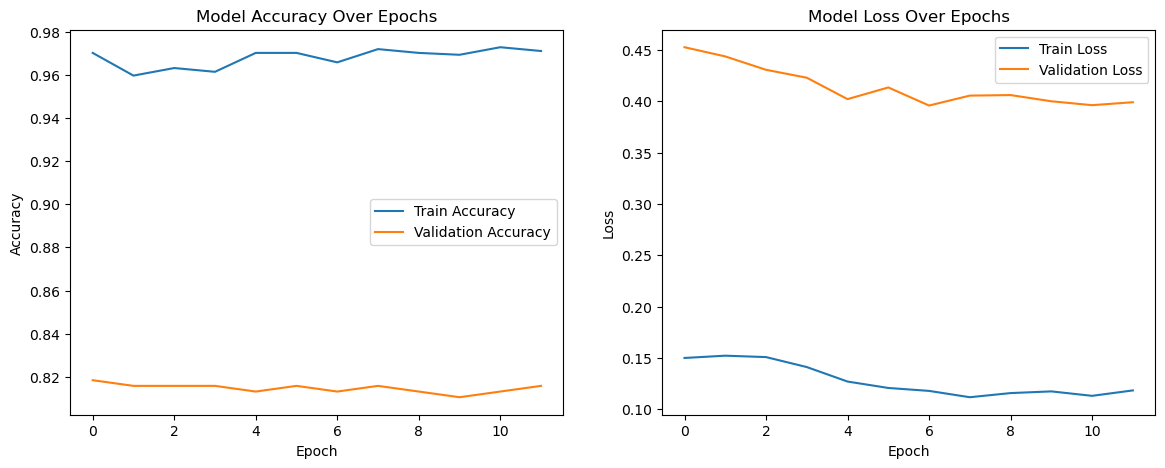

In [18]:
# Plot Training Curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [19]:
# Evaluate Model
y_true = test_generator.classes
y_pred_proba = model.predict(test_generator).flatten()
y_pred = (y_pred_proba > 0.7).astype('int32')


24/24 [==============================] - 23s 951ms/step


In [20]:
# Final Test Accuracy
final_test_acc = np.mean(y_true == y_pred)
print(f'Final Test Accuracy: {final_test_acc * 100:.2f}%')

Final Test Accuracy: 91.84%


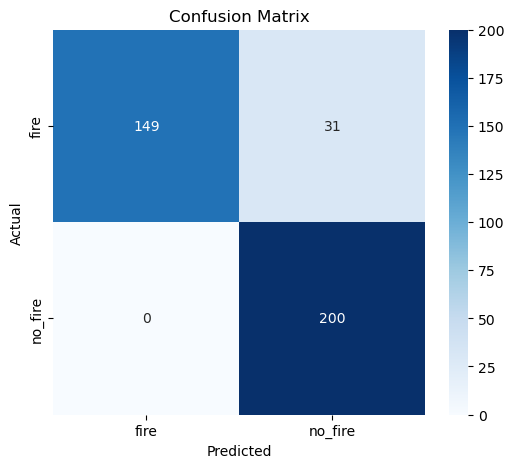

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [22]:
# Precision, Recall, F1-Score
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")


Precision: 0.8658, Recall: 1.0000, F1-Score: 0.9281


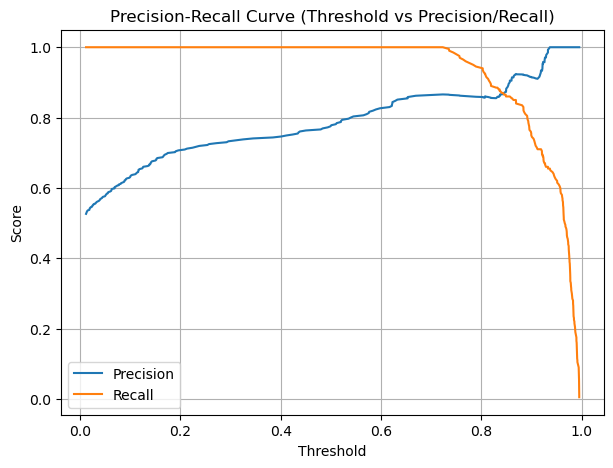

In [23]:
# Precision-Recall Curve (Plot vs Threshold)
from sklearn.metrics import precision_recall_curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_pred_proba)
plt.figure(figsize=(7, 5))
plt.plot(thresholds, precision_vals[:-1], label='Precision')
plt.plot(thresholds, recall_vals[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve (Threshold vs Precision/Recall)')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from twilio.rest import Client



In [2]:
def load_images(image_folder, img_size=(256, 256)):
    images = []
    image_filenames = sorted(os.listdir(image_folder))
    for img_name in image_filenames:
        img = cv2.imread(os.path.join(image_folder, img_name))
        img = cv2.resize(img, img_size) / 255.0
        images.append(img)
    return np.array(images)



In [3]:
def apply_gradcam(model, img_array, layer_name="block5_conv3"):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = tf.reduce_mean(predictions)
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap[0]



In [4]:
def save_gradcam(image, heatmap, filename, save_folder="gradcam_results"):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    save_path = os.path.join(save_folder, filename)
    cv2.imwrite(save_path, superimposed_img)
    print(f"Saved Grad-CAM result to {save_path}")



In [ ]:
def send_alert(location):
    account_sid = "your_twilio_account_sid"
    auth_token = "your_twilio_auth_token"
    client = Client(account_sid, auth_token)
    message = client.messages.create(
        body=f"Wildfire detected at {location}! Please take necessary precautions.",
        from_="your_twilio_phone_number",
        to="recipient_phone_number"
    )
    print("Alert sent: ", message.sid)

